In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
# make dataframe to start gathering preparing data for ML model
games = pd.read_csv('data\games_cleaned.csv')
games.head()

,time_control,moves,date,time_format,colour,my_rating,opponent_rating,opponent,outcome,my_accuracy,opponent_accuracy,rating_difference
0,10+0,62,2020-12-06,Rapid,White,557,356,methburger682,W,42.3,57.6,201
1,10+0,40,2020-12-09,Rapid,Black,643,438,JimenaGallardo,W,64.7,77.7,205
2,10+0,25,2020-12-09,Rapid,Black,531,577,DanielBrown1974,L,58.3,76.4,-46
3,10+0,64,2020-12-09,Rapid,White,625,615,RRR0007,W,81.4,77.5,10
4,10+0,12,2020-12-10,Rapid,White,564,639,prune131,L,31.6,55.5,-75


In [3]:
# remove unnecessary columns which don't have any predictive power
games.drop(columns = ['date', 'opponent'], inplace = True)

#### Since we are trying to predict the `outcome`, let's see whether our outcome variable is balanced or not and how we can mitigate any issues:

In [4]:
games.outcome.value_counts()

outcome
W    4727
L    4456
D     422
Name: count, dtype: int64

There are way fewer examples in our dataset where the outcome is a draw (`D`), while the win and loss values are more or less balanced. Since there a lot of nuances involved in the game of chess where 1 move can be the difference between a loss/win and a draw, it is best to remove our rows where the outcome is a draw, as we simply do not have enough data to train our model to learn when a game is a draw or not.

We will hence continue with a binary classification model where we are trying to determine whether a game will be a `W` or not!

In [5]:
games = games[games.outcome != 'D']
games.outcome.value_counts()

outcome
W    4727
L    4456
Name: count, dtype: int64

## Looking at Numerical features

In [6]:
# separate the numerical features
numerical_vars = ['moves', 'my_rating', 'opponent_rating', 'my_accuracy', 'opponent_accuracy', 'rating_difference']
numerical_vars_df = games[numerical_vars]

numerical_vars_df.head()

,moves,my_rating,opponent_rating,my_accuracy,opponent_accuracy,rating_difference
0,62,557,356,42.3,57.6,201
1,40,643,438,64.7,77.7,205
2,25,531,577,58.3,76.4,-46
3,64,625,615,81.4,77.5,10
4,12,564,639,31.6,55.5,-75


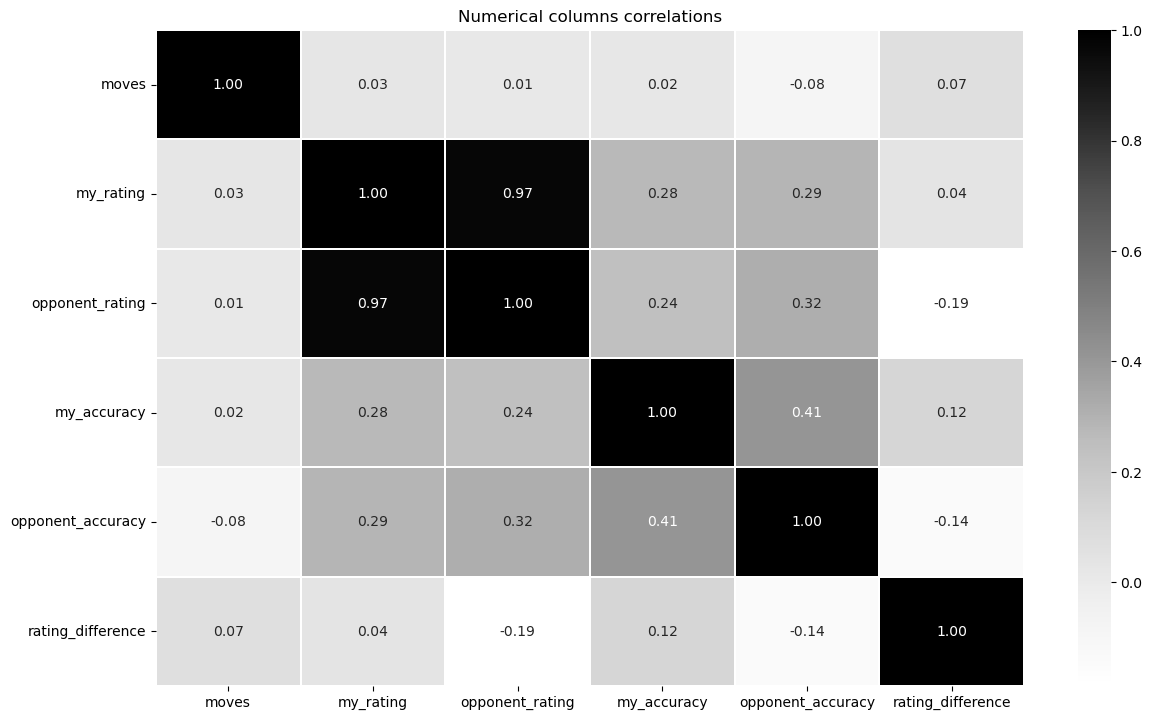

In [7]:
corr = numerical_vars_df.corr()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(corr, cmap="Greys", annot=True, fmt='.2f', linewidths=.05, ax=ax).set_title("Numerical columns correlations")
fig.subplots_adjust(top=0.93)

No alarming correlation between any of the variables, although `my_rating` and `opponent_rating` are highly correlated. If one wants to avoid using these two, one could use `rating_difference` instead for the model.

### Create groups from numerical features

- We can implement a model with the raw numerical features
- We can also implement a model with the numerical features converted into grouped categories as this may help with model interpretation.

#### `moves` coverted into categorical

We can convert this into a categorical column where if a games ends before a certain number of moves, we can categorise it as either ending in the 

- opening
- middlegame
- endgame

phases. I also have created an 'extreme' category for games that last more than 80 moves, as this is very rare.

In [8]:
numerical_vars_df.loc[:,'game_length'] = numerical_vars_df.moves.apply(lambda x: 'opening' if x <= 20
                                                                else ('middlegame' if x <= 40
                                                                else ('endgame' if x <= 80 else 'extreme')))
numerical_vars_df.game_length.value_counts()

C:\Users\zains\AppData\Local\Temp\ipykernel_12980\483006320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_vars_df.loc[:,'game_length'] = numerical_vars_df.moves.apply(lambda x: 'opening' if x <= 20


game_length
middlegame    4947
endgame       2364
opening       1822
extreme         50
Name: count, dtype: int64

#### `my_accuracy` and `opponent_accuracy` categorised

My (and my opponent's) playing accuracy can be categorised as either 

- 'poor' if accuracy is < 60%
- 'normal' if accuracy is between 60% AND 80%
- 'good' if accuracy is above 80%

In [9]:
numerical_vars_df.loc[:,'my_acc_cat'] = \
numerical_vars_df.my_accuracy.apply(lambda x: 'poor' if x < 60. else
                                   ('decent' if x < 80. else 'great'))
numerical_vars_df.loc[:,'opp_acc_cat'] = \
numerical_vars_df.opponent_accuracy.apply(lambda x: 'poor' if x < 60.0 else
                                   ('decent' if x < 80.0 else 'great'))

print(numerical_vars_df.my_acc_cat.value_counts())
print('-'*50)
print(numerical_vars_df.opp_acc_cat.value_counts())

my_acc_cat
decent    5339
great     2119
poor      1725
Name: count, dtype: int64
--------------------------------------------------
opp_acc_cat
decent    5525
great     1898
poor      1760
Name: count, dtype: int64


C:\Users\zains\AppData\Local\Temp\ipykernel_12980\3985713325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_vars_df.loc[:,'my_acc_cat'] = \
C:\Users\zains\AppData\Local\Temp\ipykernel_12980\3985713325.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_vars_df.loc[:,'opp_acc_cat'] = \


#### `rating_difference` categorised

Chesscom strives to provide users with a fair and fun experience when playing on their website. Each player has a *rating* (elo) assigned when they start and they can improve this as they get better. Part of this process means you get paired against opponent with a similar skill level as you so you can progress fairly in your career. One would consider a rating difference between themselves and their opponent

- of <= 50 normal and expected
- of between 50 AND 150 quite a big difference, there is a high chance the lower rated player will lose
- of > 150 unfair, the higher rated player will win 90% of the time

In [10]:
numerical_vars_df.loc[:,'rating_diff_cat'] = \
numerical_vars_df.rating_difference.apply(lambda x: 'similar' if abs(x) <= 50 else
                                         ('big' if abs(x) <= 150 else 'unfair'))

numerical_vars_df.rating_diff_cat.value_counts()

rating_diff_cat
similar    6617
big        2455
unfair      111
Name: count, dtype: int64

#### `my_rating` and `opponent_rating` categorised

We can consider anyone still in the triple digits in rating to be a `beginner`, as they will make many blunders and not have a sound foundation of concepts and tactics. 

An `intermediate` player will be between 1000 and 1500, this is where most chess enthusiasts stay for most of their career, to progress from here, one must study chess either from videos, courses, or books and be fairly versed in opneings, tactics, puzzles, and endgames. 

After the 1500 rating, one can consider the player to be fairly `advanced`, serious, and versed in the openings, middlegame, and endgame. Games between players of this rating will tend to be of high quality, where accuracy will usually be decent on average (~ 75%).

In [11]:
numerical_vars_df.loc[:,'my_rating_cat'] = \
numerical_vars_df.my_rating.apply(lambda x: 'beginner' if x < 1000
                                  else ('intermediate' if x < 1500 else 'advanced'))
numerical_vars_df.loc[:,'opp_rating_cat'] = \
numerical_vars_df.opponent_rating.apply(lambda x: 'beginner' if x < 1000
                                        else ('intermediate' if x < 1500 else 'advanced'))

print(numerical_vars_df.my_rating_cat.value_counts())
print('-'*50)
print(numerical_vars_df.opp_rating_cat.value_counts())
print('-'*50)

for rating_cat in list(numerical_vars_df.my_rating_cat.unique()):
    print(f'Average accuracy when I was {rating_cat}: {np.round(numerical_vars_df[numerical_vars_df.my_rating_cat == rating_cat].my_accuracy.mean(),1)}')

my_rating_cat
intermediate    6797
beginner        1312
advanced        1074
Name: count, dtype: int64
--------------------------------------------------
opp_rating_cat
intermediate    6671
beginner        1349
advanced        1163
Name: count, dtype: int64
--------------------------------------------------
Average accuracy when I was beginner: 61.8
Average accuracy when I was intermediate: 70.7
Average accuracy when I was advanced: 74.7


In [12]:
numerical_vars_df.drop(columns = numerical_vars, inplace = True)
numerical_vars_df.head()

,game_length,my_acc_cat,opp_acc_cat,rating_diff_cat,my_rating_cat,opp_rating_cat
0,endgame,poor,poor,unfair,beginner,beginner
1,middlegame,decent,decent,unfair,beginner,beginner
2,middlegame,poor,decent,similar,beginner,beginner
3,endgame,great,decent,similar,beginner,beginner
4,opening,poor,poor,big,beginner,beginner


### One-hot encoding (OHE) our numerical variables for our two different models

In [13]:
numerical_vars = list(numerical_vars_df.columns)

for var in numerical_vars:
    numerical_vars_df = pd.get_dummies(numerical_vars_df, columns = [var], prefix = [var])

for col in numerical_vars_df.columns.to_list():
    numerical_vars_df[col] = numerical_vars_df[col].astype(int)
    
numerical_vars_df.head()

,game_length_endgame,game_length_extreme,game_length_middlegame,game_length_opening,my_acc_cat_decent,my_acc_cat_great,my_acc_cat_poor,opp_acc_cat_decent,opp_acc_cat_great,opp_acc_cat_poor,rating_diff_cat_big,rating_diff_cat_similar,rating_diff_cat_unfair,my_rating_cat_advanced,my_rating_cat_beginner,my_rating_cat_intermediate,opp_rating_cat_advanced,opp_rating_cat_beginner,opp_rating_cat_intermediate
0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0
2,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
3,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
4,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0


## Looking at categorical features

In [14]:
# separate the categorical features
categorical_vars = ['time_control', 'time_format', 'colour', 'outcome']
categorical_vars_df = games[categorical_vars]

categorical_vars_df.head()

,time_control,time_format,colour,outcome
0,10+0,Rapid,White,W
1,10+0,Rapid,Black,W
2,10+0,Rapid,Black,L
3,10+0,Rapid,White,W
4,10+0,Rapid,White,L


Let's see if there is any correlation between our categorical variables by doing a chi-squared test on unique pairs of categorical features.

This will enable us to remove features that might cause our model to have high variance (overfit).

In [15]:
from scipy.stats import chi2_contingency

# Create a list to store the unique pairs
unique_pairs = []

# Generate unique pairs of categorical variables
for pair in itertools.combinations(categorical_vars_df.columns, 2):
    unique_pairs.append(pair)

# Print the unique pairs
print(unique_pairs)
print('-'*100)

for pair in unique_pairs:
    var1 = pair[0]
    var2 = pair[1]
    
    contingency_table = pd.crosstab(categorical_vars_df[var1],
                                    categorical_vars_df[var2])
    stat, pval, dof, expected = chi2_contingency(contingency_table)
    
    # define alpha value below which alternative hypothesis will be accepted
    alpha = 0.05
    print(f"The p-value is {pval}.")
    if pval <= alpha:
        print(f"The variables {var1} and {var2} are correlated.")
    else:
        print(f"There is no correlation between {var1} and {var2}.")
    print("-"*50)

[('time_control', 'time_format'), ('time_control', 'colour'), ('time_control', 'outcome'), ('time_format', 'colour'), ('time_format', 'outcome'), ('colour', 'outcome')]
----------------------------------------------------------------------------------------------------
The p-value is 0.0.
The variables time_control and time_format are correlated.
--------------------------------------------------
The p-value is 0.8526675733117649.
There is no correlation between time_control and colour.
--------------------------------------------------
The p-value is 0.5167402137237587.
There is no correlation between time_control and outcome.
--------------------------------------------------
The p-value is 0.3074547321628322.
There is no correlation between time_format and colour.
--------------------------------------------------
The p-value is 0.4585825694539737.
There is no correlation between time_format and outcome.
--------------------------------------------------
The p-value is 0.94493051168

Looks like the features `time_control` and `time_format` are highly correlated, it this makes sense to remove one of these features to prevent our model(s) from overfitting.

In [16]:
print(categorical_vars_df.time_control.value_counts())

time_control
5+0      4132
10+0     2605
3+0      2308
5+5        78
1+0        23
3+2        20
30+0        7
2+1         5
15+10       3
20+0        2
Name: count, dtype: int64


Some of the values in the time control column only appear a few times (< 100) and so there is not much data on them. Since the `time_control` and `time_format` features are highly correlated, one can continue with the `time_format` feature as it provides a nice generalisation of Rapid vs Blitz vs Bullet.

In [17]:
# also drop outcome as it is our outcome variable
categorical_vars_df.drop(columns = ['time_control', 'outcome'], inplace = True)
categorical_vars_df.head()

C:\Users\zains\AppData\Local\Temp\ipykernel_12980\440317952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars_df.drop(columns = ['time_control', 'outcome'], inplace = True)


,time_format,colour
0,Rapid,White
1,Rapid,Black
2,Rapid,Black
3,Rapid,White
4,Rapid,White


#### One-hot-encoding (OHE) our categorical features for the classification model

In [18]:
categorical_vars = list(categorical_vars_df.columns)

for var in categorical_vars:
    categorical_vars_df = pd.get_dummies(categorical_vars_df, columns = [var], prefix = [var])

for col in categorical_vars_df.columns.to_list():
    categorical_vars_df[col] = categorical_vars_df[col].astype(int)
    
categorical_vars_df.head()

,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White
0,0,0,1,0,1
1,0,0,1,1,0
2,0,0,1,1,0
3,0,0,1,0,1
4,0,0,1,0,1


### Combine all of our encoded variables into a single df 

In [19]:
games_2 = numerical_vars_df.merge(categorical_vars_df, how = 'outer',
                                      left_index = True,
                                      right_index = True)
games_2['outcome'] = games['outcome']

games_2.head()

,game_length_endgame,game_length_extreme,game_length_middlegame,game_length_opening,my_acc_cat_decent,my_acc_cat_great,my_acc_cat_poor,opp_acc_cat_decent,opp_acc_cat_great,opp_acc_cat_poor,...,my_rating_cat_intermediate,opp_rating_cat_advanced,opp_rating_cat_beginner,opp_rating_cat_intermediate,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White,outcome
0,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,W
1,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,1,0,W
2,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,0,1,1,0,L
3,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,W
4,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,L


### Prepare `games` dataframe for classification

In [20]:
games.drop(columns = ['time_control'], inplace = True)
cols_to_ohe = games.loc[:,['time_format','colour']].columns.to_list()
for col in cols_to_ohe:
    games = pd.get_dummies(games, columns = [col], prefix = [col])

for col in games.select_dtypes(bool).columns.to_list():
    games[col] = games[col].astype(int)
    
games.head()

,moves,my_rating,opponent_rating,outcome,my_accuracy,opponent_accuracy,rating_difference,time_format_Blitz,time_format_Bullet,time_format_Rapid,colour_Black,colour_White
0,62,557,356,W,42.3,57.6,201,0,0,1,0,1
1,40,643,438,W,64.7,77.7,205,0,0,1,1,0
2,25,531,577,L,58.3,76.4,-46,0,0,1,1,0
3,64,625,615,W,81.4,77.5,10,0,0,1,0,1
4,12,564,639,L,31.6,55.5,-75,0,0,1,0,1


In [21]:
games.to_csv('data\ML_processed.csv', index = False)
games_2.to_csv('data\ML_processed2.csv', index = False)